# Using Linear Tree Formulations in OMLT

In this notebook we show how OMLT can be used to build different optimization formulations of linear model decision trees within Pyomo. It specifically demonstrates the following examples:<br>
1.) A linear model decision tree represented using the GDP formulation and a Big-M transformation <br>
2.) A linear model decision tree represented using the GDP formulation and a Convex Hull transformation <br>
<br>
After building the OMLT formulations, we minimize each representation of the function and compare the results.

## Library Setup
This notebook assumes you have a working Tensorflow environment in addition to necessary Python packages described here. We use Keras to train neural networks of interest for our example which requires the Python Tensorflow package. The neural networks are then formulated in Pyomo using OMLT which therefore requires working Pyomo and OMLT installations.

The required Python libraries used this notebook are as follows: <br>
- `pandas`: used for data import and management <br>
- `matplotlib`: used for plotting the results in this example
- `linear-tree`: the machine learning language we use to train our linear model decision tree
- `scikit-learn`: another machine learning language used to for the Linear Regression models
- `pyomo`: the algebraic modeling language for Python, it is used to define the optimization model passed to the solver
- `omlt`: The package this notebook demonstates. OMLT can formulate machine learning models (such as neural networks) within Pyomo

**NOTE:** This notebook also assumes you have a working MIP solver executable (e.g., CBC, Gurobi) to solve optimization problems in Pyomo. The open-source solvers CBC and IPOPT are called by default.

In [3]:
#Start by importing the following libraries
#data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

#linear-tree objects
from lineartree import LinearTreeRegressor
from sklearn.linear_model import LinearRegression

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.lineartree import LinearTreeGDPFormulation, LinearTreeModel
import omlt

## Import the Data

We begin by training neural networks that learn from data given the following imported dataframe. In practice, this data could represent the output of a simulation, real sensor measurements, or some other external data source. The data contains a single input `x` and a single output `y` and contains 10,000 total samples

In [4]:
df = pd.read_csv("../data/sin_quadratic.csv",index_col=[0])

The data we use for training is plotted below (on the left figure). We also scale the training data to a mean of zero with unit standard deviation. The scaled inputs and outputs are added to the dataframe and plotted next to the original data values (on the right).

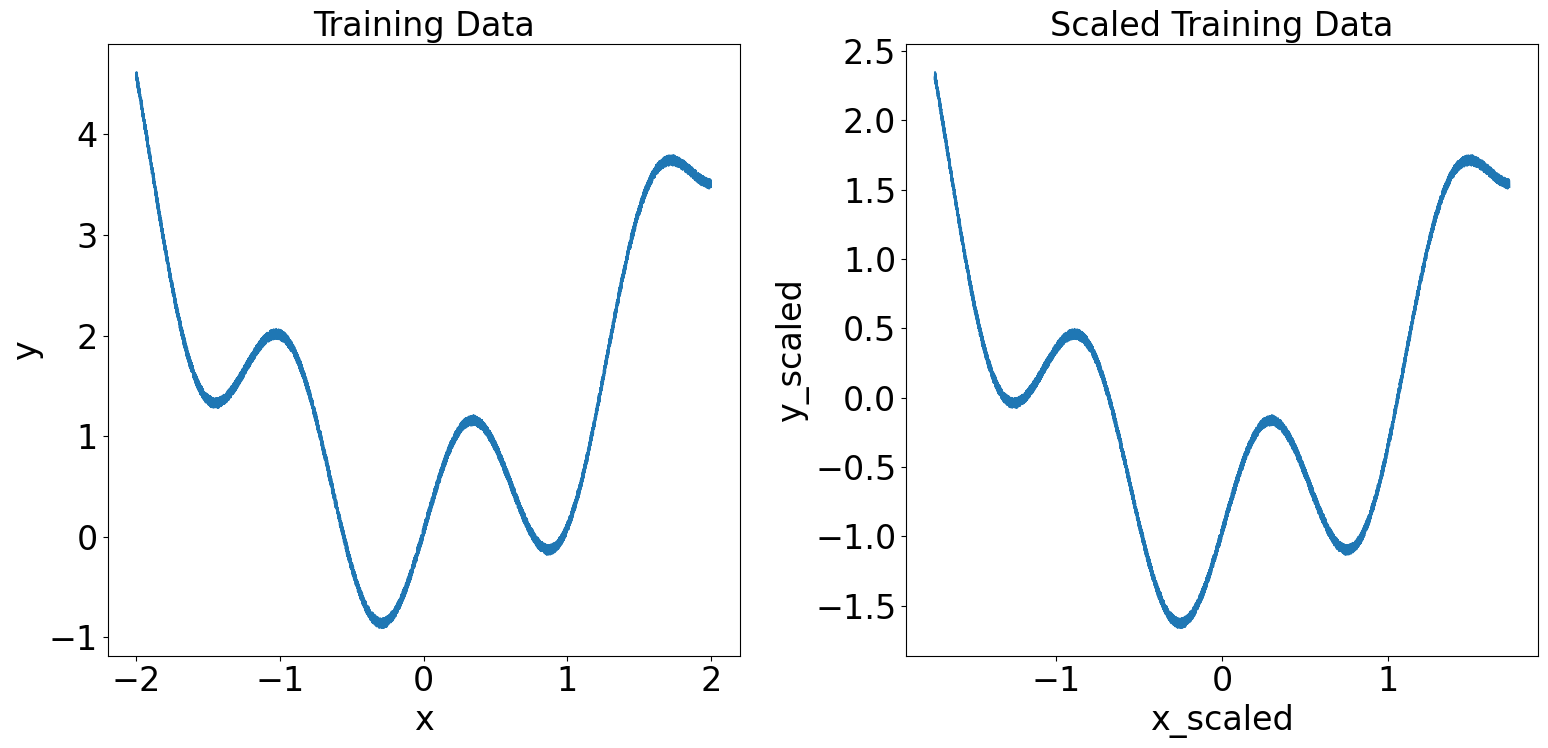

In [5]:
#retrieve input 'x' and output 'y' from the dataframe
x = df["x"]
y = df["y"]

#calculate mean and standard deviation, add scaled 'x' and scaled 'y' to the dataframe
mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

#create plots for unscaled and scaled data
f, (ax1, ax2) = plt.subplots(1, 2,figsize = (16,8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Training Data")

ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled")
ax2.set_title("Scaled Training Data")

plt.tight_layout()

## Train a Linear Model Decsion Tree using the linear-tree package

In [6]:
#Build the linear-tree model
regr = LinearTreeRegressor(LinearRegression(), 
                            criterion='mse', 
                            max_bins=120, 
                            min_samples_leaf=30, 
                            max_depth=8)

In [7]:
#Data needs to be in array and reshaped
x_scaled = df["x_scaled"].to_numpy().reshape(-1,1)
y_scaled = df["y_scaled"].to_numpy().reshape(-1,1)

#train the linear tree
history1 = regr.fit(x_scaled,y_scaled)

## Check the predictions
Before we formulate our trained neural networks in OMLT, we check to see that they adequately represent the data. While we would normally use some accuracy measure, we suffice with a visual plot of the fits.

In [8]:
#note: we calculate the unscaled output for each neural network to check the predictions
#nn1
y_predict_scaled_lt = regr.predict(x_scaled)
y_predict_lt = y_predict_scaled_lt*(std_data['y']) + mean_data['y']

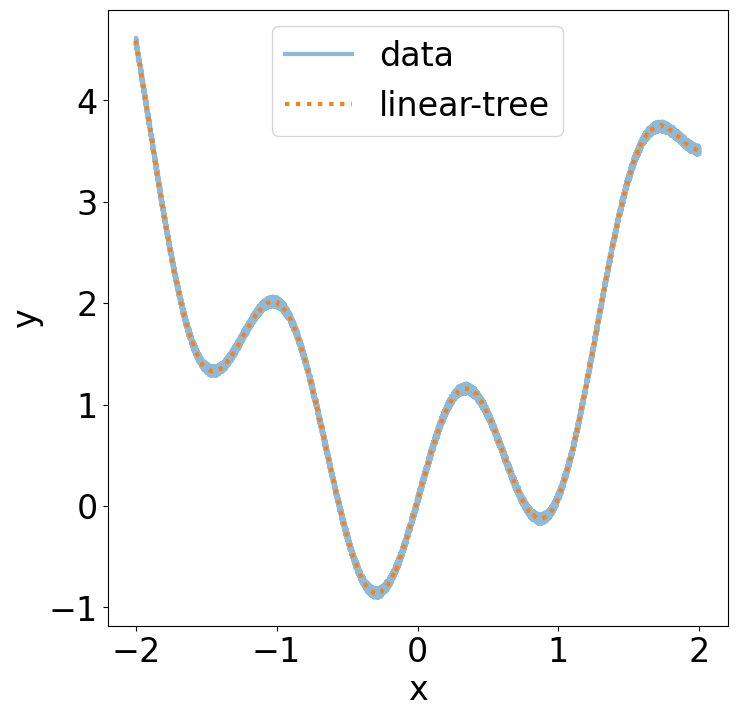

In [9]:
#create a single plot with the original data and each neural network's predictions
fig,ax = plt.subplots(1,figsize = (8,8))
ax.plot(x,y,linewidth = 3.0,label = "data", alpha = 0.5)
ax.plot(x,y_predict_lt,linewidth = 3.0,linestyle="dotted",label = "linear-tree")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

## Solving Optimization Problems with Linear Trees using OMLT

We now show how to use the above neural network formulations in OMLT for our trained neural networks: `nn1`, `nn2`, and `nn3`. For each formulation we solve the simple optimization problem below using Pyomo where we find the input $x$ that minimizes the output $\hat y$ of the neural network. 

$
\begin{align*} 
& \min_x \ \hat{y}\\
& s.t. \hat{y} = N(x) 
\end{align*}
$

For each neural network we trained, we instantiate a Pyomo `ConcreteModel` and create variables that represent the neural network input $x$ and output $\hat y$. We also create an objective function that seeks to minimize the output $\hat y$.

Each example uses the same general workflow:
- Use the `keras_reader` to import the neural network into a OMLT `NetworkDefinition` object.
- Create a Pyomo model with variables `x` and `y` where we intend to minimize `y`.
- Create an `OmltBlock`.
- Create a formulation object. Note that we use `ReducedSpaceSmoothNNFormulation` for the reduced-space and various full-space formulations for full-space and ReLU. 
- Build the formulation object on the `OmltBlock`.
- Add constraints connecting `x` to the neural network input and `y` to the neural network output.
- Solve with an optimization solver (this example uses ipopt).
- Query the solution.

We also print model size and solution time following each cell where we optimize the Pyomo model. 

### Setup scaling and input bounds
We assume that our Pyomo model operates in the unscaled space with respect to our neural network inputs and outputs. We additionally assume input bounds to our neural networks are given by the limits of our training data. 

To handle this, OMLT can be given scaling information (in the form of an OMLT scaling object) and input bounds (in the form of a dictionary where indices correspond to neural network indices and values are 2-length tuples of lower and upper bounds). This maintains the space of the optimization problem and scaling is handled by OMLT underneath. The scaling object and input bounds are passed to keras reader method `load_keras_sequential` when importing the associated neural networks. 

In [10]:
#create an omlt scaling object
scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                    factor_inputs=[std_data['x']],
                    offset_outputs=[mean_data['y']],
                    factor_outputs=[std_data['y']])

#create the input bounds. note that the key `0` corresponds to input `0` and that we also scale the input bounds
input_bounds={0:((min(df['x']) - mean_data['x'])/std_data['x'],
                 (max(df['x']) - mean_data['x'])/std_data['x'])};
print(scaler)
print("Scaled input bounds: ",input_bounds)

Scaled input bounds:  {0: (-1.7317910151019957, 1.7317910151019957)}


## Neural Network 1: Sigmoid Activations with Full-Space and Reduced-Space Formulations
The first neural network contains sigmoid activation functions which we formulate with full-space and reduced-space representations and solve with Ipopt.

### Reduced Space Model
We begin with the reduced-space formulation and build the Pyomo model according to the above workflow. Note that the reduced-space model only contains 6 variables (`x` and `y` created on the Pyomo model, and the `OmltBlock` scaled and unscaled input and output which get created internally). The full-space formulation (shown next) will contain many more.

In [11]:
#create a LinearTreeModel Object
ltmodel = LinearTreeModel(regr,scaler,input_bounds)

#create a pyomo model with variables x and y
model1 = pyo.ConcreteModel()
model1.x = pyo.Var(initialize = 0)
model1.y = pyo.Var(initialize = 0)
model1.obj = pyo.Objective(expr=(model1.y))

#create an OmltBlock
model1.lt = OmltBlock()

#use the reduced-space formulation
formulation1_lt = LinearTreeGDPFormulation(ltmodel, transformation='bigm')
model1.lt.build_formulation(formulation1_lt)

#connect pyomo variables to the neural network
@model1.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.lt.inputs[0]

@model1.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.lt.outputs[0]

#solve the model and query the solution
status_1_lt = pyo.SolverFactory('gurobi').solve(model1, tee=True)
solution_1_lt = (pyo.value(model1.x),pyo.value(model1.y))

lt : Size=1, Index=None, Active=True
    2 Set Declarations
        inputs_set : Size=1, Index=None, Ordered=Insertion
            Key  : Dimen : Domain : Size : Members
            None :     1 :    Any :    1 :    {0,}
        outputs_set : Size=1, Index=None, Ordered=Insertion
            Key  : Dimen : Domain : Size : Members
            None :     1 :    Any :    1 :    {0,}

    4 Var Declarations
        inputs : Size=1, Index=lt.inputs_set
            Key : Lower : Value : Upper : Fixed : Stale : Domain
              0 :  -2.0 :     0 :   2.0 : False : False :  Reals
        outputs : Size=1, Index=lt.outputs_set
            Key : Lower : Value : Upper : Fixed : Stale : Domain
              0 :  None :     0 :  None : False : False :  Reals
        scaled_inputs : Size=1, Index=lt.inputs_set
            Key : Lower               : Value : Upper              : Fixed : Stale : Domain
              0 : -1.7317910151019957 :     0 : 1.7317910151019957 : False : False :  Reals
     

In [12]:
#print out model size and solution values
print("Reduced Space Solution:")
print("# of variables: ",model1.nvariables())
print("# of constraints: ",model1.nconstraints())
print("x = ", solution_1_lt[0])
print("y = ", solution_1_lt[1])
print("Solve Time: ", status_1_lt['Solver'][0]['Time'])

Reduced Space Solution:
# of variables:  105
# of constraints:  401
x =  -0.2857157680604126
y =  -0.861263304620608
Solve Time:  0.15732765197753906


### Final Plots and Discussion

We lastly plot the results of each optimization problem. Some of the main take-aways from this notebook are as follows:
- A broad set of dense neural network architectures can be represented in Pyomo using OMLT. This notebook used the Keras reader to import sequential Keras models but OMLT also supports using ONNX models (see `import_network.ipynb`). OMLT additionally supports Convolutional Neural Networks (see `mnist_example_cnn.ipynb`).
- The reduced-space formulation provides a computationally tractable means to represent neural networks that contain smooth activation functions and can be used with continuous optimizers to obtain local solutions.
- The full-space formulation permits representing ReLU activation functions using either complementarity or 'BigM' approaches with binary variables (as well as partition-based approaches).
- The full-space formulation further allows one to optimize over neural networks that contain mixed activation functions by formulating ReLU logic as complementarity conditions.
- Using binary variables to represent ReLU (with Big-M) allows the use of global MIP solvers (if the rest of the optimization problem permits), whereas the complementarity formulation permits the use of local solvers that tend to be more scalable (if there are no binary/integer variables).
- The partition formulation can normally be used to improve upon the Big-M formulation, but in this notebook they are equivalent because there is only one input in the neural network.

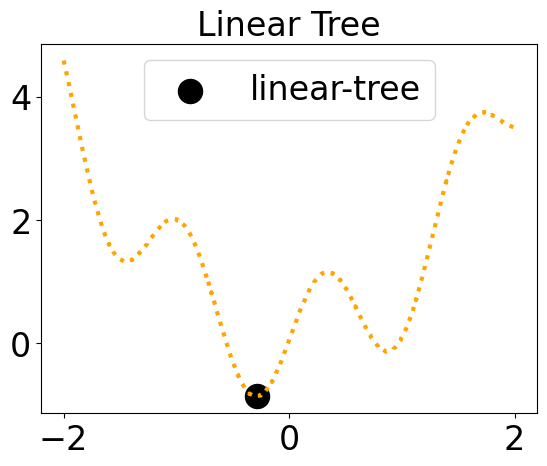

In [18]:


#nn1 - sigmoid
plt.plot(x,y_predict_lt,linewidth = 3.0,linestyle="dotted",color = "orange")
plt.title("Linear Tree")
plt.scatter([solution_1_lt[0]],[solution_1_lt[1]],color = "black",s = 300, label="linear-tree")
plt.legend()